In [167]:
import gzip
from collections import defaultdict
from sklearn import linear_model
import csv
import random
import numpy as np
import pickle

import os
import json
import pandas as pd
import copy
import random

import scipy
import scipy.optimize

import collections
from gensim.models import Word2Vec
from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.manifold import TSNE


import matplotlib.pyplot as plt

import sklearn
import string


In [2]:
data = []
with gzip.open('data\Grocery_and_Gourmet_Food_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

1143860
{'overall': 5.0, 'verified': True, 'reviewTime': '11 19, 2014', 'reviewerID': 'A1QVBUH9E1V6I8', 'asin': '4639725183', 'reviewerName': 'Jamshed Mathur', 'reviewText': 'No adverse comment.', 'summary': 'Five Stars', 'unixReviewTime': 1416355200}


In [3]:
required_vals=['overall','verified','reviewerID','asin','reviewText','summary','unixReviewTime']
data_cleaned=[]
cnt=0
imgcnt=0
for d in data: 
    add=True 
    for i in required_vals:
        if i not in d:
            add=False 
    if add:
        dcopy=copy.deepcopy(d) #not sure if this is really needed, will most likely remove
        if 'image' in dcopy:
            imgcnt+=1
            dcopy['hasImage']=1
        else:
            dcopy['hasImage']=0
        data_cleaned.append(dcopy)


    

In [4]:
print(imgcnt)
#this is  small so the image feature might be useless 

9474


In [5]:
#shuffle dataset
random.shuffle(data_cleaned)
train_data=data_cleaned[:int((len(data_cleaned)+1)*.80)]
val_data=data_cleaned[int((len(data_cleaned)+1)*.80):]

In [6]:
train_set=[]
test_set=[]
cnt=0

itemsPerUser=defaultdict(set)
usersPerItem=defaultdict(set)
items=set()
itemCount=defaultdict(int) # keep track of total times an item is reviewed

for review in train_data:
    user=review['reviewerID']
    item=review['asin']
    itemsPerUser[user].add(item)
    usersPerItem[item].add(user)
    items.add(item)
    itemCount[item]+=1

    flist=[]
    flist.append(user)
    flist.append(item)
    flist.append(review['overall'])
    train_set.append(flist)


for review in val_data:
    flist=[]
    flist.append(review['reviewerID'])
    flist.append(review['asin'])
    flist.append(review['overall'])
    test_set.append(flist)



# See "simple bias only latent factor model"
https://cseweb.ucsd.edu//classes/fa20/cse258-a/code/workbook4.html

This is a basic latent factor model from prev assignment (needs to be improved). Uses information only from user item pairs and ratings

In [141]:
labels= [int(d['overall']) for d in train_data]
ratingMean = sum([int(d['overall']) for d in train_data]) / len(train_data)
ratingMean

4.442140790742527

In [142]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

val_labels= [int(d['overall']) for d in val_data]
alwaysMean=[ratingMean]*len(val_labels)
baselineMSE=MSE(alwaysMean,val_labels)
baselineMSE

1.1367579747015757

In [136]:
occurrences = collections.Counter(labels)
trainmse_list=[]
testmse_list=[]

In [132]:
def get_test_preds(test_set):
    X=[]
    userSet=set(users)# doing this to improve lookup time
    itemSet=set(items)
    for  u,i,s in test_set:
        y.append(s)
        case_1=u in userSet
        case_2=i in itemSet
        if case_1 and case_2:
            X.append(prediction(u,i))
            continue
        elif case_1 and not case_2:
            p=alpha+userBiases[u]
            if p<0:
                p=0
            if p>5:
                p=5
            X.append(p)
            continue
        elif case_2 and not case_1:
            p=alpha+itemBiases[i]
            if p<0:
                p=0
            if p>5:
                p=5
            X.append(p)
            continue
        else:
            X.append(alpha)
    return X,y

In [133]:

N = len(train_set)
nUsers = len(itemsPerUser)
nItems = len(usersPerItem)
users = list(itemsPerUser.keys())
items = list(usersPerItem.keys())
alpha = ratingMean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)
def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(d[0], d[1]) for d in train_set]
    cost = MSE(predictions, labels)
    test_preds,test_labels=get_test_preds(test_set)
    mse_test=MSE(test_preds, test_labels)
    trainmse_list.append(cost)
    testmse_list.append(mse_test)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(train_set)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for d in train_set:
        u,i = d[0], d[1]
        pred = prediction(u, i)
        diff = pred - int(d[2])
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return np.array(dtheta)


In [11]:

#basic  latent factor model from prev assignment (needs to be improved)
scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, .0001))

MSE = 1.1308026933786226
MSE = 1.123494643180019
MSE = 1.3801577839909287
MSE = 1.1219526597275666
MSE = 1.1144653694943045
MSE = 1.1137677095780343
MSE = 1.1110799659060562
MSE = 1.1019753271072044
MSE = 1.0853022823796694
MSE = 1.0712746448360957
MSE = 1.0464222575040165
MSE = 1.0342632561866645
MSE = 1.0311546960455593
MSE = 1.031264525691905
MSE = 1.0288459044939853
MSE = 1.0261955393259998
MSE = 1.0232785110486933
MSE = 1.024613985531601
MSE = 1.0233062589108715
MSE = 1.024146519274313
MSE = 1.0232865330801724
MSE = 1.0231201132102732
MSE = 1.0231330902609403
MSE = 1.0232722170502955
MSE = 1.0230834381404676
MSE = 1.0231411982457022
MSE = 1.0229669499701335
MSE = 1.0228033787692967
MSE = 1.0226462128638882
MSE = 1.0225521725230073
MSE = 1.0225780320036422
MSE = 1.022527852724066
MSE = 1.0225537806828744
MSE = 1.022587249789403
MSE = 1.0226776380940696
MSE = 1.022631136113244
MSE = 1.0226527677596342
MSE = 1.0226357415238818
MSE = 1.0226138061896677
MSE = 1.0225708108061429
MSE = 1

(array([4.41754651e+00, 1.38768021e-02, 7.52129313e-03, ...,
        1.67582618e-03, 6.30508625e-03, 5.96515691e-03]),
 1.0654853592995777,
 {'grad': array([-6.46130275e-06,  1.10523183e-09,  8.17370982e-11, ...,
          2.75804715e-10, -4.44652679e-09, -1.00949612e-09]),
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 59,
  'nit': 50,
  'warnflag': 0})

In [130]:
X=[]
y=[]
cnt=0
userSet=set(users)# doing this to improve search speed
itemSet=set(items)
for  u,i,s in test_set:
    # if cnt%1000==0:
    #     print(cnt)
    # cnt+=1
    y.append(s)
    case_1=u in userSet
    case_2=i in itemSet
    if case_1 and case_2:
        X.append(prediction(u,i))
        continue
    elif case_1 and not case_2:
        p=alpha+userBiases[u]
        if p<0:
            p=0
        if p>5:
            p=5
        X.append(p)
        continue
    elif case_2 and not case_1:
        p=alpha+itemBiases[i]
        if p<0:
            p=0
        if p>5:
            p=5
        X.append(p)
        continue
    else:
        X.append(alpha)
    

In [131]:
MSE_val=MSE(X,y)
MSE_val

1.061770693765833

## Item2vect rating prediction based on chapter 8.5 
https://cseweb.ucsd.edu/~jmcauley/pml/code/chap8.html

In [29]:
train_data[0]

{'overall': 5.0,
 'verified': True,
 'reviewTime': '02 12, 2016',
 'reviewerID': 'A2I5E58DMYF3E1',
 'asin': 'B0042GZXNM',
 'reviewerName': 'Shell.',
 'reviewText': 'Very yummy candy.  Was given to my husband as a gift and he was thrilled.',
 'summary': 'Very yummy candy. Was given to my husband as ...',
 'unixReviewTime': 1455235200,
 'hasImage': 0}

In [49]:
ratingMean = sum([d['overall'] for d in train_data]) / len(train_data)

In [165]:
reviewsPerUser = defaultdict(list)
itemAverages = defaultdict(list)

data = []
reviews = []
reviewDicts = []
for d in train_data:  
    reviews.append(d['reviewText'])
    reviewsPerUser[d['reviewerID']].append((d['unixReviewTime'], d['asin']))
    itemAverages[i].append(d['overall'])
    reviewDicts.append(d)

for i in itemAverages:
    itemAverages[i] = sum(itemAverages[i]) / len(itemAverages[i])
        

In [166]:
reviewLists = []
for u in reviewsPerUser:
    rl = list(reviewsPerUser[u])
    rl.sort()
    print(rl)
    print([x[1] for x in rl])
    print(ggh)
    break
    reviewLists.append([x[1] for x in rl])


[(1449619200, 'B00F4WIL8C'), (1449619200, 'B00K0OYRUK'), (1455235200, 'B0042GZXNM'), (1455235200, 'B004T33F3I'), (1456272000, 'B0042GSLRW'), (1456272000, 'B00DLN8LLS')]
['B00F4WIL8C', 'B00K0OYRUK', 'B0042GZXNM', 'B004T33F3I', 'B0042GSLRW', 'B00DLN8LLS']


NameError: name 'ggh' is not defined

In [157]:
reviewLists[:2]

[['B00F4WIL8C',
  'B00K0OYRUK',
  'B0042GZXNM',
  'B004T33F3I',
  'B0042GSLRW',
  'B00DLN8LLS'],
 ['B000QX948U', 'B0014WYXYW', 'B0014WYXYW', 'B001LFABO8', 'B004A7AEA0']]

In [80]:
model10 = Word2Vec(reviewLists,
                 min_count=2, # Words/items with fewer instances are discarded
                 vector_size=20, # Model dimensionality
                 window=3, # Window size
                 sg=1) # Skip-gram model

In [81]:
itemAverages = defaultdict(list)
reviewsPerUser = defaultdict(list)
    
for d in train_data:
    u = d['reviewerID']
    i = d['asin']
    itemAverages[i].append(d['overall'])
    reviewsPerUser[u].append(d)
    
for i in itemAverages:
    itemAverages[i] = sum(itemAverages[i]) / len(itemAverages[i])

In [82]:
def predictRating(user,item):
    ratings = []
    similarities = []
    if not str(item) in model10.wv:
        return ratingMean
    for d in reviewsPerUser[user]:
        i2 = d['asin']
        if i2 == item: continue
        ratings.append(d['overall'] - itemAverages[i2])
        if str(i2) in model10.wv:
            similarities.append(model10.wv.distance(str(item), str(i2)))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        return ratingMean

In [83]:
predictions = [predictRating(d['reviewerID'],d['asin']) for d in val_data]

In [84]:
val_y=[d['overall'] for d in val_data]

In [85]:
item2vectMSE=MSE(predictions,val_y)
item2vectMSE

1.1495287838469772

In [89]:
best_min_count=0
bestmse=10.0
for i in [5,7,10]:
    model10 = Word2Vec(reviewLists,
                 min_count=i, # Words/items with fewer instances are discarded
                 vector_size=10, # Model dimensionality
                 window=3, # Window size
                 sg=1) # Skip-gram model
    predictions = [predictRating(d['reviewerID'],d['asin']) for d in val_data]
    item2vectMSE=MSE(predictions,val_y)
    print(i,item2vectMSE)
    if item2vectMSE<bestmse:
        bestmse=item2vectMSE
        best_min_count=i
print("Best MSE: ",bestmse)
print('best_min_count',best_min_count)
    
    

5 1.1448871165243772
7 1.1398976027529528
10 1.1445327410141317
Best MSE:  1.1398976027529528
best_min_count 7


In [92]:
bestmse=10.0
best_vsize=0
for i in [40,75,150]:
    model10 = Word2Vec(reviewLists,
                 min_count=best_min_count, # Words/items with fewer instances are discarded
                 vector_size=i, # Model dimensionality
                 window=3, # Window size
                 sg=1) # Skip-gram model
    predictions = [predictRating(d['reviewerID'],d['asin']) for d in val_data]
    item2vectMSE=MSE(predictions,val_y)
    print(i,item2vectMSE)
    if item2vectMSE<bestmse:
        bestmse=item2vectMSE
        best_vsize=i
print("Best MSE: ",bestmse)
print('best dimensionality: ',best_vsize)

40 1.119184064718971
75 1.1178892833309342
150 1.1187175645839997
Best MSE:  1.1178892833309342
best dimensionality:  75


In [143]:
bestmse=10.0
best_window=0
for i in [1,2,3,4,6,8,10,15]:
    model10 = Word2Vec(reviewLists,
                 min_count=best_min_count, # Words/items with fewer instances are discarded
                 vector_size=best_vsize, # Model dimensionality
                 window=i, # Window size
                 sg=1) # Skip-gram model
    predictions = [predictRating(d['reviewerID'],d['asin']) for d in val_data]
    item2vectMSE=MSE(predictions,val_y)
    print(i,item2vectMSE)
    if item2vectMSE<bestmse:
        bestmse=item2vectMSE
        best_window=i
print("Best MSE: ",bestmse)
print('best window: ',best_window)

1 1.130595224968943
2 1.1223753452841718
3 1.1180897193779304
4 1.1164537668870351
6 1.1150721623300248
8 1.114856081099899
10 1.1138654500837424
15 1.1122792917057345
Best MSE:  1.1122792917057345
best window:  15


In [144]:
bestmse=10.0
best_sg=0
for i in [1,2,3,5]:
    model10 = Word2Vec(reviewLists,
                 min_count=best_min_count, # Words/items with fewer instances are discarded
                 vector_size=best_vsize, # Model dimensionality
                 window=best_window, # Window size
                 sg=i) # Skip-gram model
    predictions = [predictRating(d['reviewerID'],d['asin']) for d in val_data]
    item2vectMSE=MSE(predictions,val_y)
    print(i,item2vectMSE)
    if item2vectMSE<bestmse:
        bestmse=item2vectMSE
        best_sg=i
print("Best MSE: ",bestmse)
print('best sg: ',best_sg)

1 1.1123156252742379
2 1.112202919121322
3 1.1122999278512766
5 1.1119852563753378
Best MSE:  1.1119852563753378
best sg:  5


In [137]:
scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, .0001))
model10 = Word2Vec(reviewLists,
                min_count=best_min_count, # Words/items with fewer instances are discarded
                vector_size=best_vsize, # Model dimensionality
                window=best_window, # Window size
                sg=best_sg) # Skip-gram model




MSE = 1.1314075719598384
MSE = 2.05313483971613
MSE = 1.1307649738557053
MSE = 1.1307282599972748
MSE = 1.1305818192266248
MSE = 1.1300026907402028
MSE = 1.127792330335482
MSE = 1.0979551227349242
MSE = 1.0778581132065521
MSE = 1.0576590216401627
MSE = 1.0520503655768219
MSE = 1.0443886090254975
MSE = 1.036073908102167
MSE = 1.0263962470162253
MSE = 1.0228488494052232
MSE = 1.0250127661054311
MSE = 1.0252198995271176
MSE = 1.0245157635342867
MSE = 1.0557573240594558
MSE = 1.0244994607628946
MSE = 1.0236172315571768
MSE = 1.0231615873264615
MSE = 1.022784743477697
MSE = 1.0225284110548123
MSE = 1.0226255134013615
MSE = 1.0225574465791194
MSE = 1.0227048172048
MSE = 1.0227574411406142
MSE = 1.0227254665400345
MSE = 1.022657693473297
MSE = 1.0226211533868168
MSE = 1.022577530767866
MSE = 1.022519993613212
MSE = 1.022551906246914
MSE = 1.0225493861216741
MSE = 1.0225649232419651
MSE = 1.0225793321498566
MSE = 1.0226060161285757
MSE = 1.022613651262331
MSE = 1.0226154460177797
MSE = 1.02261

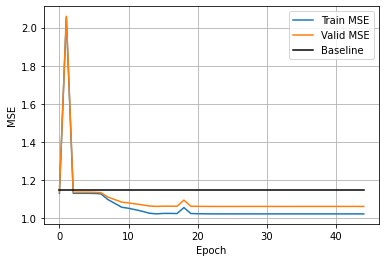

In [153]:
xdata=np.arange(len(trainmse_list))
baseline=np.full(xdata.shape,1.149)
plt.plot(xdata, trainmse_list, label = "Train MSE")
plt.plot(xdata, testmse_list, label = "Valid MSE")
plt.plot(xdata,baseline,'k',label="Baseline")
plt.plot()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()



In [149]:
xdata.shape

(45,)

In [96]:
X=[]
y=[]
cnt=0
userSet=set(users)# doing this to improve search speed
itemSet=set(items)
for  u,i,s in train_set:
    # if cnt%1000==0:
    #     print(cnt)
    # cnt+=1
    y.append(s)
    case_1=u in userSet
    case_2=i in itemSet
    if case_1 and case_2:
        X.append(prediction(u,i))
        continue
    elif case_1 and not case_2:
        p=alpha+userBiases[u]
        if p<0:
            p=0
        if p>5:
            p=5
        X.append(p)
        continue
    elif case_2 and not case_1:
        p=alpha+itemBiases[i]
        if p<0:
            p=0
        if p>5:
            p=5
        X.append(p)
        continue
    else:
        X.append(alpha)


In [107]:
xlatent_preds=X
xitem_preds=[predictRating(d['reviewerID'],d['asin']) for d in train_data]


In [109]:
X=[]
y=[]
cnt=0
userSet=set(users)# doing this to improve search speed
itemSet=set(items)
for  u,i,s in test_set:
    # if cnt%1000==0:
    #     print(cnt)
    # cnt+=1
    y.append(s)
    case_1=u in userSet
    case_2=i in itemSet
    if case_1 and case_2:
        X.append(prediction(u,i))
        continue
    elif case_1 and not case_2:
        p=alpha+userBiases[u]
        if p<0:
            p=0
        if p>5:
            p=5
        X.append(p)
        continue
    elif case_2 and not case_1:
        p=alpha+itemBiases[i]
        if p<0:
            p=0
        if p>5:
            p=5
        X.append(p)
        continue
    else:
        X.append(alpha)

In [110]:
x_testlatent_preds=X
x_testitem_preds=[predictRating(d['reviewerID'],d['asin']) for d in val_data]

In [111]:
ytrain=[float(d['overall']) for d in train_data]
ytest=[float(d['overall']) for d in val_data]

In [112]:
trainX=[]
testX=[]
for p1,p2 in zip(xlatent_preds,xitem_preds):
    entry=[1]
    entry.append(p1)
    entry.append(p2)
    trainX.append(entry)
for p1,p2 in zip(x_testlatent_preds,x_testitem_preds):
    entry=[1]
    entry.append(p1)
    entry.append(p2)
    testX.append(entry)

In [113]:
testX[0]

[1, 4.45770421274468, 3.5192083803421177]

In [115]:
model = linear_model.LinearRegression()
model.fit(trainX,ytrain)
yPred = model.predict(testX)
EnsembleMSE = MSE(yPred, ytest)

In [116]:
EnsembleMSE

0.9955440470942178

In [179]:
t_data=train_data[:50000]

In [180]:
punctuation = set(string.punctuation)

def feature(datum, words, wordId, tolower=True, removePunct=True):
    feat = [0]*len(words)
    r = datum['reviewText']
    if tolower:
        r = r.lower()
    if removePunct:
        r = ''.join([c for c in r if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [181]:
def pipeline(dSize = 1000, tolower=True, removePunct=True):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in t_data: # Strictly, should just use the *training* data to extract word counts
        r = d['reviewText']
        if tolower:
            r = r.lower()
        if removePunct:
            r = ''.join([c for c in r if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1

    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()
    
    words = [x[1] for x in counts[:dSize]]
    
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)
    
    X = [feature(d, words, wordId, tolower, removePunct) for d in t_data]
    y = [d['overall'] for d in t_data]
    
    Ntrain,Nvalid,Ntest = 40000,5000,5000
    Xtrain,Xvalid,Xtest = X[:Ntrain],X[Ntrain:Ntrain+Nvalid],X[Ntrain+Nvalid:]
    ytrain,yvalid,ytest = y[:Ntrain],y[Ntrain:Ntrain+Nvalid],y[Ntrain+Nvalid:]
    
    bestModel = None
    bestVal = None
    bestLamb = None
    
    ls = [0.01, 0.1, 1, 10, 100, 1000, 10000]
    errorTrain = []
    errorValid = []

    for l in ls:
        model = sklearn.linear_model.Ridge(l)
        model.fit(Xtrain, ytrain)
        predictTrain = model.predict(Xtrain)
        MSEtrain = sum((ytrain - predictTrain)**2)/len(ytrain)
        errorTrain.append(MSEtrain)
        predictValid = model.predict(Xvalid)
        MSEvalid = sum((yvalid - predictValid)**2)/len(yvalid)
        errorValid.append(MSEvalid)
        print("l = " + str(l) + ", validation MSE = " + str(MSEvalid))
        if bestVal == None or MSEvalid < bestVal:
            bestVal = MSEvalid
            bestModel = model
            bestLamb = l
            
    predictTest = bestModel.predict(Xtest)
    MSEtest = sum((ytest - predictTest)**2)/len(ytest)
    MSEtest
    
    plt.xticks([])
    plt.xlabel(r"$\lambda$")
    plt.ylabel(r"error (MSE)")
    plt.title(r"Validation Pipeline")
    plt.xscale('log')
    plt.plot(ls, errorTrain, color='k', linestyle='--', label='training error')
    plt.plot(ls, errorValid, color='grey',zorder=4,label="validation error")
    plt.plot([bestLamb], [MSEtest], linestyle='', marker='x', color='k', label="test error")
    plt.legend(loc='best')
    plt.show()

l = 0.01, validation MSE = 0.8303432543934889
l = 0.1, validation MSE = 0.8302467581070676
l = 1, validation MSE = 0.829305963784672
l = 10, validation MSE = 0.8218627492805712
l = 100, validation MSE = 0.8074688344514782
l = 1000, validation MSE = 0.8552356498836075
l = 10000, validation MSE = 0.9545895094490535


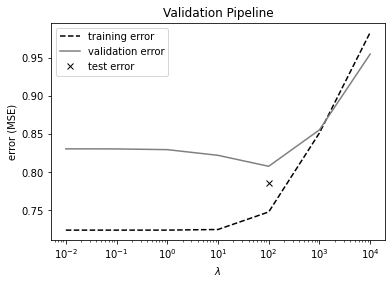

In [184]:
pipeline(2000, False, False)

l = 0.01, validation MSE = 0.8049243750007515
l = 0.1, validation MSE = 0.8047815507807689
l = 1, validation MSE = 0.8033914406411887
l = 10, validation MSE = 0.7925206104874164
l = 100, validation MSE = 0.7686069658995609
l = 1000, validation MSE = 0.8085172452579312
l = 10000, validation MSE = 0.9114140098538668


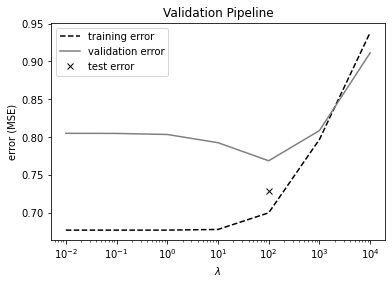

In [185]:
pipeline(2000, True, True)